<a href="https://colab.research.google.com/github/gladwel/DIP/blob/main/DAO_summarization_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [375]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')

import re, string, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess

# Exploratory Data Analysis

Exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. This step is absolutely necessary and has a huge impact on the final result of a model, this analysis will tell us what type of transformation we need to apply to our data. When we face a machine learning problem, we must begin by analyzing the input dataset, seeking to identify its characteristics and anomalies.

## Read data

In [376]:
data_path = 'data/'
analysis_path = 'data_analysis/'
data_filename = 'proposals_06_04.csv'
# Load the data from the file system
summary = pd.read_csv(data_path + data_filename)
summary_original = summary.copy()
summary = summary[
    summary['middleDescription'].notna() & summary['juniorDescription'].notna() & summary['seniorDescription'].notna()]
summary.drop_duplicates(subset=["seniorDescription"], inplace=True)

summary

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber
0,69,[ARC] Add MaticX to Polygon v3 Market,3,Stader is proposing that the Aave v3 Polygon m...,Stader is proposing that the Aave v3 Polygon m...,# Summary\r\n\r\nStader proposes addition of M...,1660510860000,1661115540000,0xc290Cfb8D020c0615e9C63036f4319Cc41717E68,1660394707282,0x88e896a245ffeda703e0b8f5494f3e66628be6e32a72...,https://governance.aave.com/t/proposal-to-add-...,https://snapshot.org/#/aave.eth/proposal/0x88e...,NaN,NaN
1,89,Should we deploy Uniswap v3 on Aurora?,2,The proposal is to deploy Uniswap v3 on Aurora...,The proposal is to deploy Uniswap v3 on Aurora...,## Summary\r\n\r\nThis proposal is created on ...,1662982755000,1663970400000,0x13BDaE8c5F0fC40231F0E6A4ad70196F59138548,1662983122731,0x2f72d9f247d9ce143809bbb4af7f5b36aa50895e517c...,https://gov.uniswap.org/t/temperature-check-un...,https://snapshot.org/#/uniswap/proposal/0x2f72...,NaN,NaN
2,29,[EP14] [Social] Dissolve Community Working Group,6,This proposal is to dissolve the Community Wor...,The proposal is to dissolve the Community Work...,This vote proposes to dissolve the Community W...,1654858800000,1655290800000,0x75cac0ceb8a39ddb4942a83ad2aafaf0c2a3e13f,1658311692253,0xa64ec8b446e509cb4b75092c4a714897790b70e2711f...,https://discuss.ens.domains/t/draft-social-dis...,https://snapshot.org/#/ens.eth/proposal/0xa64e...,NaN,29.0
3,745,Should the dYdX Community Transition from Comm...,19,This passage is proposing that the dYdX govern...,This passage is proposing that the dYdX govern...,In reference to this discussion:\r\nhttps://co...,1680230173000,1680575773000,0xccC4e8Ad313dF8150211B1b934725345924ab81D,1680144307983,0xa5e77732dd24edd26bd41b089969b3662c29eb41c3ba...,https://commonwealth.im/dydx/discussion/10584-...,https://snapshot.org/#/dydxgov.eth/proposal/0x...,NaN,684.0
4,345,[ARC] Compensate Bug Bounty Contributor,3,The proposal is to reward an individual who fo...,The proposal is to reward an individual who fo...,## Simple Summary\r\n\r\nCompensate contributo...,1674272100000,1674876900000,0xDD659911EcBD4458db07Ee7cDdeC79bf8F859AbC,1674186308534,0x4f97f52ef593bbdddc1037597729e1575ed8d4df997c...,https://governance.aave.com/t/arc-compensate-b...,https://snapshot.org/#/aave.eth/proposal/0x4f9...,NaN,280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,789,[AGIP 73] Liquidity Provision: Adding the $2.5...,29,This text is a proposal to the directors of th...,This text is a proposal to the directors of th...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717344000,1681322100000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607218,0x9d2a5cbe986c1c1f30132c3e396470e6b67f7d74ce2a...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,737.0
699,791,[AGIP 72] Liquidity Provision: Reimbursement o...,29,This proposal is about using $5 million of DAI...,This proposal is about using $5 million of DAI...,**Author:** Maxicrouton#1596\r\n**Gotchi ID:**...,1680717147000,1681321920000,0xb8B95A513C2F754AE61087edfe0057c80513e649,1680717607284,0x7fe819f1bba47d2322d4bb1f1b796a3a13c96146ac90...,https://dao.aavegotchi.com/t/where-should-25-l...,https://snapshot.org/#/aavegotchi.eth/proposal...,NaN,736.0
700,807,[BIP-240] Enable rETH/bb-a-wETH Gauge [Arbitrum],12,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,https://github.com/BalancerMaxis/multisig-ops/...,1680796800000,1681142400000,0x512fce9B07Ce64590849115EE6B32fd40eC0f5F3,1680776108847,0xc9b885108fe8ddc26109e1a2626d5b90b7a52883b894...,https://forum.balancer.fi/t/bip-240-enable-ret...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,798.0
701,808,[BIP-241] Aave v3 Migration,12,This proposal is about transitioning from the ...,This proposal is about transitioning from the ...,https://github.com/BalancerMaxis/multisig-ops/.

In [377]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 0 to 702
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 691 non-null    int64  
 1   title              691 non-null    object 
 2   daoId              691 non-null    int64  
 3   juniorDescription  691 non-null    object 
 4   middleDescription  691 non-null    object 
 5   seniorDescription  691 non-null    object 
 6   startAt            691 non-null    int64  
 7   endAt              691 non-null    int64  
 8   author             691 non-null    object 
 9   createdAt          691 non-null    int64  
 10  snapshotId         691 non-null    object 
 11  discussionLink     608 non-null    object 
 12  snapshotLink       691 non-null    object 
 13  userId             0 non-null      float64
 14  issueNumber        636 non-null    float64
dtypes: float64(2), int64(5), object(8)
memory usage: 86.4+ KB


## Clean data

In [378]:
def remove_right_empty_whitespace(text, symbol):
    return text.replace(f'{symbol} ', symbol)

def remove_left_empty_whitespace(text, symbol):
    return text.replace(f' {symbol}', symbol)

def preprocess_text(text):
    # Replace ![Image](...) or [Image](...) with [image]
    text = re.sub(r'!?\[Image\]\(.*?\)', '[image]', text)
    text = re.sub(r'\w+\.(?:jpg|jpeg|png|gif|bmp)', '[image]', text)

    # Replace all links
    text = re.sub(r'(https?://|www\.|ipfs://)[^\s\])]+', r'[link]', text)

    # Change "[Screenshot 2022-07-04 at 19.47.49.png]" to "[Screenshot]"
    text = re.sub(r'\[Screenshot.*?\]', '[Screenshot]', text)

    # Replace hexadecimal address
    text = re.sub(r'0x[a-fA-F0-9]+|\'0x[a-fA-F0-9]+\'', '[hexadecimals]', text)

    # Change more than 3 '-' to '---'
    text = re.sub(r'(-){3,}', '---', text)

    # Replace ’,`,«,»,„, and “ with "
    text = text.replace('’', "'").replace('`', "'")
    text = re.sub(r'[«»„“]', '"', text)

    # Delete all emails
    text = re.sub(r'\S+@\S+', '', text)

    # Replace \'s with 's
    text = re.sub(r'\'s', 's', text)

    # Correct "\r\n"s
    text = re.sub(r'(\r\n)+', '\r\n', text)

    # Remove "bulleted list" *
    text = re.sub(r'\r\n\*', ' ', text)

    # Remove \r\n after non-punctuation symbols
    text = re.sub(r'([^{}])\r\n'.format(re.escape(string.punctuation)), r'\1. ', text)

    # Correct final "\r\n"
    text = re.sub(r'\r\n', ' ', text)

    text = re.sub(r'(\t)+', ' ', text)

    # Correct "(!)"
    text = re.sub(r'((!\())+', '(', text)
    text = re.sub(r'((!\)))+', ')', text)

    # Correct "#, ##, ### / *, **, ***"
    text = re.sub(r'#+', '', text)
    text = re.sub(r'\*+', '', text)
    text = re.sub(r'\'+', '\'', text)

    # Correct (, ), [, ]
    text = remove_right_empty_whitespace(text, '(')
    text = remove_left_empty_whitespace(text, ')')
    text = remove_right_empty_whitespace(text, '[')
    text = remove_left_empty_whitespace(text, ']')

    # Other corrections
    text = re.sub(r'\(>', '', text)
    text = re.sub(r'[…]', '...', text)

    # Delete empty () and []
    while '()' in text:
        text = text.replace('()', '')
    while '[]' in text:
        text = text.replace('[]', '')

    # Remove more than one consecutive space
    text = re.sub(r' +', ' ', text)

    # Delete all non ASCII characters
    text = ''.join(char for char in text if char in string.punctuation or char.isalnum() or char == ' ')

    # remove all .+ after punctuation symbols
    text = re.sub(r'([{}])(\.)+'.format(re.escape(string.punctuation)), r'\1', text)

    # # Replace all ..
    text = re.sub(r'\.\.', '.', text)

    ## Delete all punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation))

    ## Delete all system text
    # text = re.sub(r'\[.*?\]', '', text)

    return text.strip()

In [379]:
summary['seniorDescription'] = summary['seniorDescription'].apply(lambda x: preprocess_text(x))
summary['juniorDescription'] = summary['juniorDescription'].apply(lambda x: preprocess_text(x))

In [380]:
a, b = 15, 30
summary['seniorDescription'].tolist()[a:b]

['This proposals expectation is to produce an implementation. Full details and discussions thus far can be found at: [link] Synopsis: Sushis Treasury currently has 41,424.01 TOKE ($963,522.47) that could be utilized for staking at a potential APR between 16% - 31% The main initiative is to make Sushis treasury more productive. The yield earned will help sustain the protocol in the long run. It could be used to help cover fees for setting up the Swiss Association, operations fees etc. TL;DR. Stake $TOKE  Allocate votes to reactors (Weekly voting required)  Direct liquidity to Sushiswap  More fees earned by Sushi & xSushi holders',
 'We propose to increase by 500,000 LDO the number of incentives for the [Shard Labs]([link]) team who makes Lido on Polygon to1,500,000 LDO total to reflect that Polygon importance had risen relatively since the [first proposal]([link]) and that the deal was different from our baseline for other networks as well. Hence, we advocate for the increase with the f

In [381]:
summary_original['seniorDescription'].tolist()[a:b]

['This proposal’s expectation is to produce an implementation. Full details and discussions thus far can be found at:\r\n\r\nhttps://forum.sushi.com/t/lets-get-toke/9935\r\n\r\nSynopsis:\r\nSushi’s Treasury currently has 41,424.01 TOKE ($963,522.47) that could be utilized for staking at a potential APR between 16% - 31%.\r\n\r\nThe main initiative is to make Sushi’s treasury more productive. The yield earned will help sustain the protocol in the long run. It could be used to help cover fees for setting up the Swiss Association, operations fees etc.\r\n\r\nTL;DR\r\nStake $TOKE → Allocate votes to reactors (Weekly voting required) → Direct liquidity to Sushiswap → More fees earned by Sushi & xSushi holders',
 'We propose to increase by 500,000 LDO the number of incentives for the [Shard Labs](https://shardlabs.io) team who makes Lido on Polygon to\xa0**1,500,000 LDO total** to reflect that Polygon importance had risen relatively since the [first proposal](https://research.lido.fi/t/lido-

Delete rows with seniorDescription length less than 200

In [382]:
summary['seniorLength'] = summary['seniorDescription'].str.len().astype(int)
summary['middleLength'] = summary['middleDescription'].str.len().astype(int)
summary['juniorLength'] = summary['juniorDescription'].str.len().astype(int)
summary[summary['seniorLength'] <= 200]

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber,seniorLength,middleLength,juniorLength
55,40,"Temp Check: ""Fee switch"" activation for ETH/US...",2,The proposal is about designing a fee switch f...,The proposal is about designing a fee switch f...,See governance forum for details: [link],1658184092000,1658412000000,0x067b9Bbbbc42d2AB9b9Ab6bB62646dAF7F344A76,1659342474755,0x4dd49ee723a7e506c6c6c15c8eabc8a7057f3f0760e4...,https://gov.uniswap.org/t/fee-switch-design-sp...,https://snapshot.org/#/uniswap/proposal/0x4dd4...,NaN,40.0,40,108,108
84,68,[Consensus Check] Create the Uniswap Foundation,2,The passage is about a proposal to create the ...,The passage is about a proposal to create the ...,Read the full proposal here: [link],1660138758000,1660572000000,0xf665F2eD351696817898fe0Ace20c5C1Bc3c5796,1660139104117,0xd70b3e84db501c2633bc8189fcfc335726fce90584a3...,https://gov.uniswap.org/t/consensus-check-crea...,https://snapshot.org/#/uniswap/proposal/0xd70b...,NaN,68.0,35,217,217
103,118,Optimism-Uniswap Protocol LM Program: Pool sel...,2,1. The first proposal is to select the WETH/US...,1. The first proposal is to select the WETH/US...,"Which pools should be selected? 1. WETH/USDC, ...",1665747505000,1666008000000,0xf665F2eD351696817898fe0Ace20c5C1Bc3c5796,1665748804788,0x255d43357e17858f8664ffaaeaf7660bfd8be5f7dabc...,https://gov.uniswap.org/t/rfc-the-optimism-uni...,https://snapshot.org/#/uniswap/proposal/0x255d...,NaN,91.0,121,230,228
138,44,"[Consensus Check] ""Fee switch"" Pilot for Three...",2,The passage is about a proposal to test out a ...,The passage is about a proposal to test out a ...,See governance forum for details: [link],1659639419000,1660075200000,0x067b9Bbbbc42d2AB9b9Ab6bB62646dAF7F344A76,1659639610081,0xe9f8e5dd7ec26f7c0e7dd9e19bb8d57497d27d4a74be...,https://gov.uniswap.org/t/consensus-check-fee-...,https://snapshot.org/#/uniswap/proposal/0xe9f8...,NaN,44.0,40,522,522
150,269,Execution of the proposal: Purchase $OPIUM Opt...,8,The proposal is about creating a pool of money...,The proposal is about creating a pool of money...,Execution of the proposal: Purchase $OPIUM Opt...,1671433200000,1671606000000,0x84E94F8032b3F9fEc34EE05F192Ad57003337988,1671440408850,0xc80a960b9c07f7f3e26c6f550db90fa52bd4e76ac01c...,https://forum.opium.network/t/proposal-run-liq...,https://snapshot.org/#/opiumprotocol.eth/propo...,NaN,207.0,62,421,421


In [383]:
summary = summary[summary['seniorLength'] > 200]  # sort summary by id
summary = summary.sort_values(by=['id'])

Delete all rows with juniorDescription contains 'Proposal is too long'

In [384]:
summary = summary[summary['juniorDescription'] != 'Proposal is too long']

In [385]:
summary

,id,title,daoId,juniorDescription,middleDescription,seniorDescription,startAt,endAt,author,createdAt,snapshotId,discussionLink,snapshotLink,userId,issueNumber,seniorLength,middleLength,juniorLength
390,1,[1IP-07] Integrate Balancer Boosted Pools in t...,1,The proposal is about integrating Balancer Boo...,This proposal calls for the integration of Bal...,Simple Summary. This proposal calls for the in...,1651554223000,1652159023000,0x824732d3f4eb94a20254cca9de10485ce445bb40,1657200979740,0x6358c27cd2d5a95e58095e5cc3b1b9a85d2c9af2a363...,https://gov.1inch.io/t/1ip-07-integrate-balanc...,https://snapshot.org/#/1inch.eth/proposal/0x63...,NaN,1.0,4325,320,290
25,2,[1IP-06] Donation of 1inch DAO Treasury Funds ...,1,The 1inch DAO Treasury is proposing to donate ...,The 1inch DAO is proposing to donate 1 million...,Summary. 1inch Network was founded on core val...,1646760014000,1647364814000,0x824732d3f4eb94a20254cca9de10485ce445bb40,1657200981507,0xf4f712189924944dfd1cb438dc3235f4f4d5493f8c9d...,NaN,https://snapshot.org/#/1inch.eth/proposal/0xf4...,NaN,2.0,2631,365,302
317,3,[Temperature Check] Should the Uniswap communi...,2,The Protocol Guild is a council of Ethereum pr...,"The authors are proposing that 500,000 UNI (ab...","Authors: [Trent]([link]) (PG Member), [Tim]([l...",1654176425000,1654437600000,0x4c0a466df0628fe8699051b3ac6506653191cc21,1657200982022,0x7f196c3444623a33ac147d1676d84e45d3c4c56a94ba...,https://gov.uniswap.org/t/temperature-check-sh...,https://snapshot.org/#/uniswap/proposal/0x7f19...,NaN,3.0,7165,504,330
388,4,Aave V3 Harmony - Freeze Reserves,3,The proposal is about freezing all reserves on...,"The Aave DAO Community, through the governance...",title: Aave V3 Harmony - Freeze Reserves. stat...,1657807792000,1658138400000,0xd2362dbb5aa708bc454ce5c3f11050c016764fa6,1658239945117,0x81a78109941e5e0ac6cb5ebf82597c839c20ad6821a8...,https://governance.aave.com/t/aave-v3-harmony-...,https://snapshot.org/#/aave.eth/proposal/0x81a...,NaN,4.0,1675,879,275
209,5,Revised ARC: Add 1INCH as collateral,3,The proposal seeks to add 1inch Networks 1INCH...,1inch Network is a decentralized set of protoc...,Summary. 1inch is a network of decentralized p...,1657638000000,1657983600000,0xc290cfb8d020c0615e9c63036f4319cc41717e68,1658239945766,0x2ea76814a0dfcad7ea1a7b3c597f059a8d574f814388...,https://governance.aave.com/t/arc-add-1inch-as...,https://snapshot.org/#/aave.eth/proposal/0x2ea...,NaN,5.0,11552,745,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,805,[BIP-237] Enable USH - ETH 50/50 Gauge with 10...,12,This proposal is about adding a gauge to the n...,This proposal is about adding a gauge to the n...,[PR with Payload]([link]) Summary: Proposal to...,1680796800000,1681142400000,0x9f74662aD05840Ba35d111930501c617920dD68e,1680720307179,0x495c40b72c0bc24173c4ebdfb7ac3986bd3978fcae20...,https://forum.balancer.fi/t/bip-237-enable-ush...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,783.0,7328,731,731
695,806,[BIP-239] Enable bb-a-USD gauge [Ethereum],12,This passage is describing a proposal to add a...,This passage is describing a proposal to add a...,[PR with Payload]([link]) Summary This is a pr...,1680796800000,1681142400000,0x9f74662aD05840Ba35d111930501c617920dD68e,1680720307225,0x7e2f179b46a590b28d8f2d6641db8ccad415a152a558...,https://forum.balancer.fi/t/bip-239-enable-bb-...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,795.0,1572,561,561
700,807,[BIP-240] Enable rETH/bb-a-wETH Gauge [Arbitrum],12,This proposal is for a new pool on Arbitrum cr...,This proposal is for a new pool on Arbitrum cr...,[link] Summary: > This pool uses the Composabl...,1680796800000,1681142400000,0x512fce9B07Ce64590849115EE6B32fd40eC0f5F3,1680776108847,0xc9b885108fe8ddc26109e1a2626d5b90b7a52883b894...,https://forum.balancer.fi/t/bip-240-enable-ret...,https://snapshot.org/#/balancer.eth/proposal/0...,NaN,798.0,2902,735,734
701,808,[BIP-241] Aave v3 Migration,12,This proposal is about transitioning 

In [386]:
# summary = summary[
#     ['seniorDescription', 'middleDescription', 'juniorDescription', 'seniorLength', 'middleLength', 'juniorLength']]

## Exploring relevant features in the data

### Statistical Count Features from headlines and text

Storing the sets of punctuation in variable result

In [387]:
punc = string.punctuation
stop_words = stopwords.words('english')
print(punc)
print(stop_words)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

In [388]:
def split_words(text):
    ''' Return the number of words in the text (without symbols)
        Input:
            - text: string
        Output:
            - int, number of words in the text argument
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [389]:
def list_stopwords(text, stopwords):
    ''' Return stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = split_words(text)  #splitta i pezzi
    stopwords_x = [w for w in word_tokens if w in stopwords]
    return stopwords_x

def remove_stopwords(texts):
    ''' Remove stopwords from a list of texts
        Input:
            - texts: list of string, containing the texts
        Output:
            - list of string, texts without stopwords
    '''
    return [[word for word in simple_preprocess(str(text))
             if word not in stop_words] for text in texts]


In [390]:
# Number of sentences in the summary
summary['sum_sent_count'] = summary['juniorDescription'].apply(lambda x: len(sent_tokenize(x)))
# Number of sentences in the text
# TODO fix sentence amount problems (example id=396)
summary['text_sent_count'] = summary['seniorDescription'].apply(lambda x: len(sent_tokenize(x)))

# Number of word in the summary
summary['sum_word_count'] = summary['juniorDescription'].apply(lambda x: len(split_words(x)))
# Number of word in the text
summary['text_word_count'] = summary['seniorDescription'].apply(lambda x: len(split_words(x)))

# Number of characters in the summary
summary['sum_char_count'] = summary['juniorDescription'].apply(lambda x: len(x.replace(" ", "")))
# Number of characters in the text
summary['text_char_count'] = summary['seniorDescription'].apply(lambda x: len(x.replace(" ", "")))

# Density of words in the summary
summary['sum_word_density'] = summary['sum_word_count'] / (summary['sum_char_count'] + 1)
# Density of words in the text
summary['text_word_density'] = summary['text_word_count'] / (summary['text_char_count'] + 1)

# Density of sentences in the summary
summary['sum_sent_density'] = summary['sum_sent_count'] / (summary['sum_word_count'] + 1)
# Density of sentences in the text
summary['text_sent_density'] = summary['text_sent_count'] / (summary['text_word_count'] + 1)

# Number of punctuations in the summary
summary['sum_punc_count'] = summary['juniorDescription'].apply(lambda x: len([a for a in x if a in punc]))
# Number of punctuations in the text
summary['text_punc_count'] = summary['seniorDescription'].apply(lambda x: len([a for a in x if a in punc]))

# Stopwords
# Number of stopwords in the text
summary['text_stopw_count'] = summary['seniorDescription'].apply(lambda x: len(list_stopwords(x, stop_words)))
# Number of stopwords in the summary
summary['sum_stopw_count'] = summary['juniorDescription'].apply(lambda x: len(list_stopwords(x, stop_words)))

# Density of stopwords in the summary
summary['sum_stopw_density'] = summary['sum_stopw_count'] / (summary['sum_word_count'] + 1)
# Density of stopwords in the text
summary['text_stopw_density'] = summary['text_stopw_count'] / (summary['text_word_count'] + 1)

summary.describe()

,id,daoId,startAt,endAt,createdAt,userId,issueNumber,seniorLength,middleLength,juniorLength,...,sum_word_density,text_word_density,sum_sent_density,text_sent_density,sum_punc_count,text_punc_count,text_stopw_count,sum_stopw_count,sum_stopw_density,text_stopw_density
count,685.000000,685.000000,6.850000e+02,6.850000e+02,6.850000e+02,0.0,631.000000,685.000000,685.000000,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,406.778102,11.408759,1.672857e+12,1.673313e+12,1.673204e+12,NaN,366.792393,3401.112409,539.113869,526.989781,...,0.198433,0.188437,0.040957,0.057219,10.810219,146.537226,184.148905,32.608759,0.371464,0.329353
std,235.747568,8.200302,7.449292e+09,7.496158e+09,6.435594e+09,NaN,214.257944,2829.742497,201.452406,202.627265,...,0.014885,0.015304,0.009506,0.017009,5.701560,129.505358,169.467755,12.242622,0.048276,0.054917
min,1.000000,1.000000,1.638640e+12,1.638899e+12,1.657201e+12,NaN,1.000000,245.000000,73.000000,73.000000,...,0.162353,0.109121,0.011628,0.014085,1.000000,9.000000,6.000000,5.000000,0.157895,0.084507
25%,210.000000,3.000000,1.669918e+12,1.670263e+12,1.669900e+12,NaN,191.500000,1375.000000,405.000000,387.000000,...,0.188406,0.180418,0.034884,0.046620,7.000000,56.000000,72.000000,24.000000,0.340206,0.295918
50%,410.000000,12.000000,1.675361e+12,1.675868e+12,1.675271e+12,NaN,366.000000,2614.000000,532.000000,525.000000,...,0.197065,0.189693,0.040541,0.055215,10.000000,110.000000,136.000000,32.000000,0.369565,0.333071
75%,613.000000,14.000000,1.678097e+12,1.678464e+12,1.678047e+12,NaN,538.500000,4360.000000,663.000000,648.000000,...,0.207585,0.197894,0.046296,0.065789,14.000000,200.000000,219.000000,40.000000,0.401639,0.364238
max,809.000000,31.000000,1.680797e+12,1.696061e+12,1.680786e+12,NaN,800.000000,13502.000000,1201.000000,1198.000000,...,0.252525,0.247475,0.086957,0.135922,44.000000,971.000000,945.000000,75.000000,0.529412,0.461538


### Analyze the feature distributions

In [391]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figsize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containing the columns to plot
        - labels: a dictionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    nrows, ncols = plot_vars.shape
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=figsize)

    for i in range(nrows):
        for j in range(ncols):
            if plot_vars[i, j] is not None:
                ax = axes[i, j] if nrows > 1 else axes[j]
                ax.set_title(labels[plot_vars[i, j]])
                ax.grid(True)
                ax.tick_params(
                    axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False)
                ax.boxplot(data[plot_vars[i, j]])

            else:
                axes[i, j].set_visible(False)

    f.tight_layout()
    plt.show()


def plot_histograms(data, plot_vars, labels, figsize):
    ''' Function to plot the histograms of the variables in plot_vars
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containing the columns to plot
        - labels: a dictionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''

    fig, axes = plt.subplots(1, plot_vars.shape[1], figsize=figsize, sharey='none', dpi=100)

    for i in range(plot_vars.shape[1]):
        color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        sns.histplot(data=data, x=plot_vars[0, i], ax=axes[i], color=color, bins=50, stat='density', kde=True)
        axes[i].set_xlabel(labels[plot_vars[0, i]])

    fig.tight_layout()


ratio = 0.5
fig_size = (10 / ratio, 3 / ratio)

#### Analyze the feature distributions on the seniorDescription variable

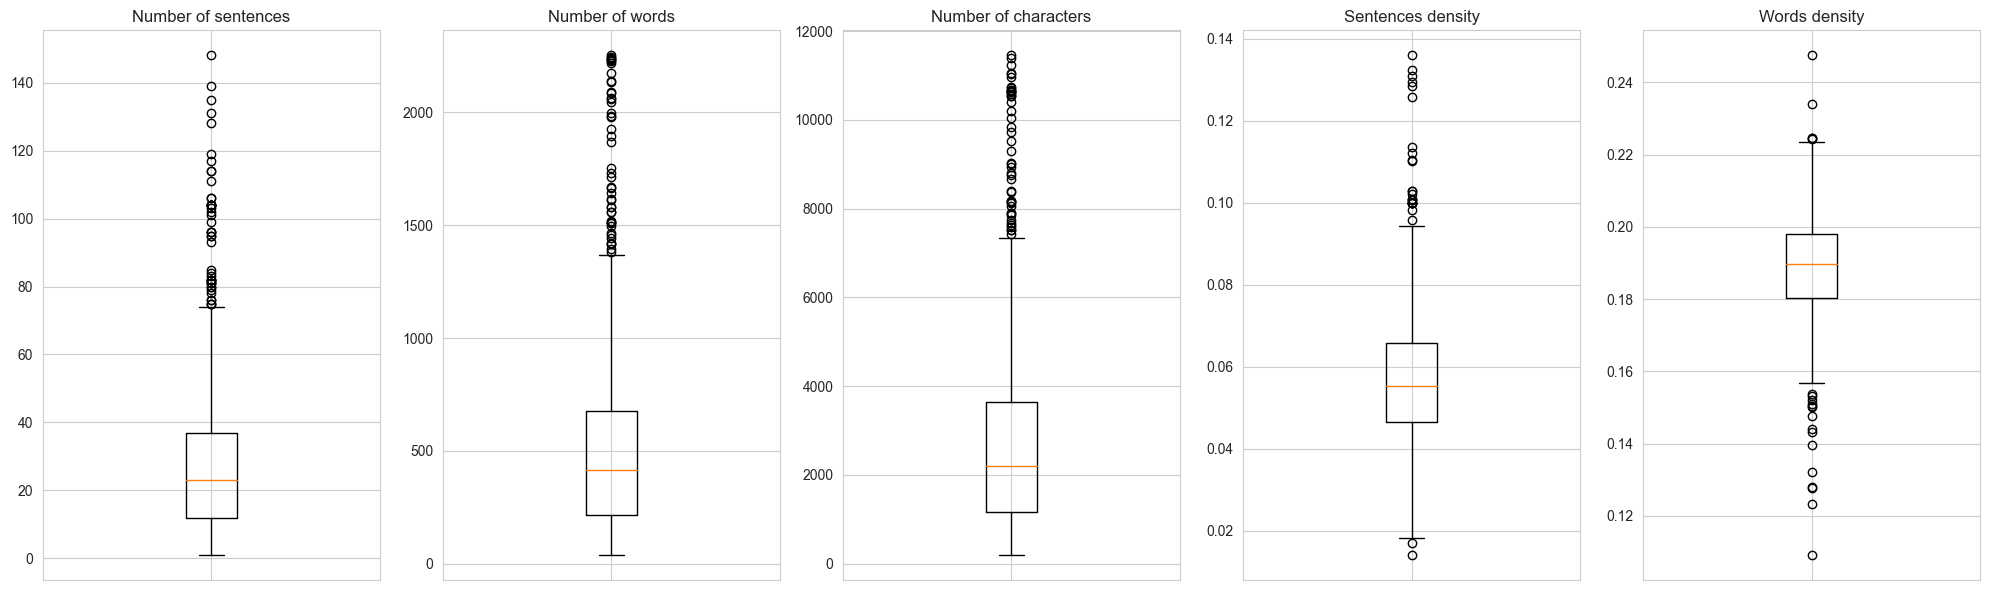

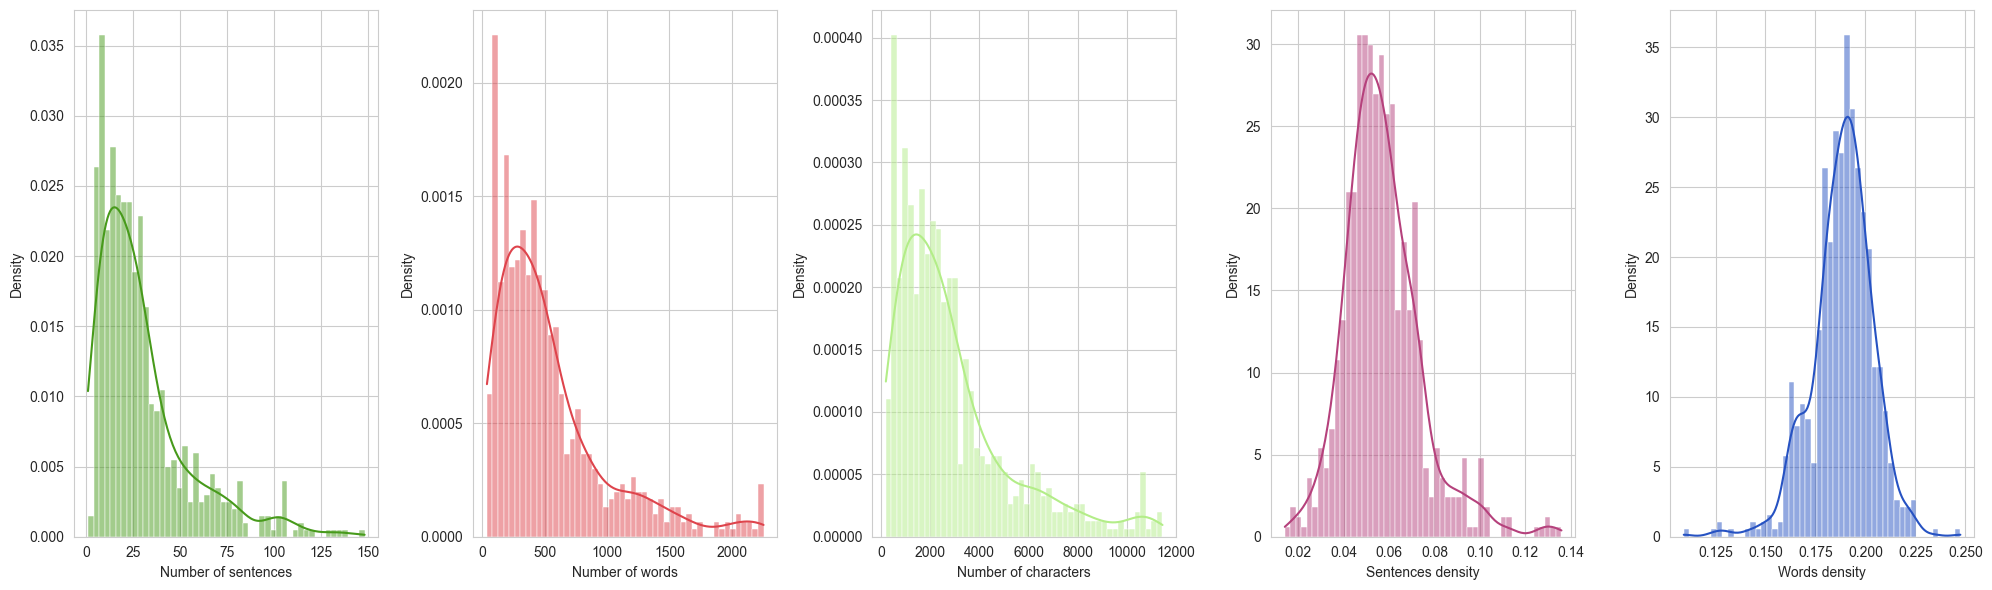

In [392]:
#Set the columns to plot
plot_vars = np.array(
    [['text_sent_count', 'text_word_count', 'text_char_count', 'text_sent_density', 'text_word_density']])
labels_dict = {'text_sent_count': 'Number of sentences', 'text_word_count': 'Number of words',
               'text_char_count': 'Number of characters', 'text_sent_density': 'Sentences density',
               'text_word_density': 'Words density'}
# Plot the boxplots for the interesting columns
plot_boxplots(summary, plot_vars, labels_dict, figsize=fig_size)
# Plot the histograms
plot_histograms(summary, plot_vars, labels_dict, figsize=fig_size)

TODO make description of the plots (The distribution appears to be right-skewed, as the mean...)

#### Analyze the feature distributions on the juniorDescription variable

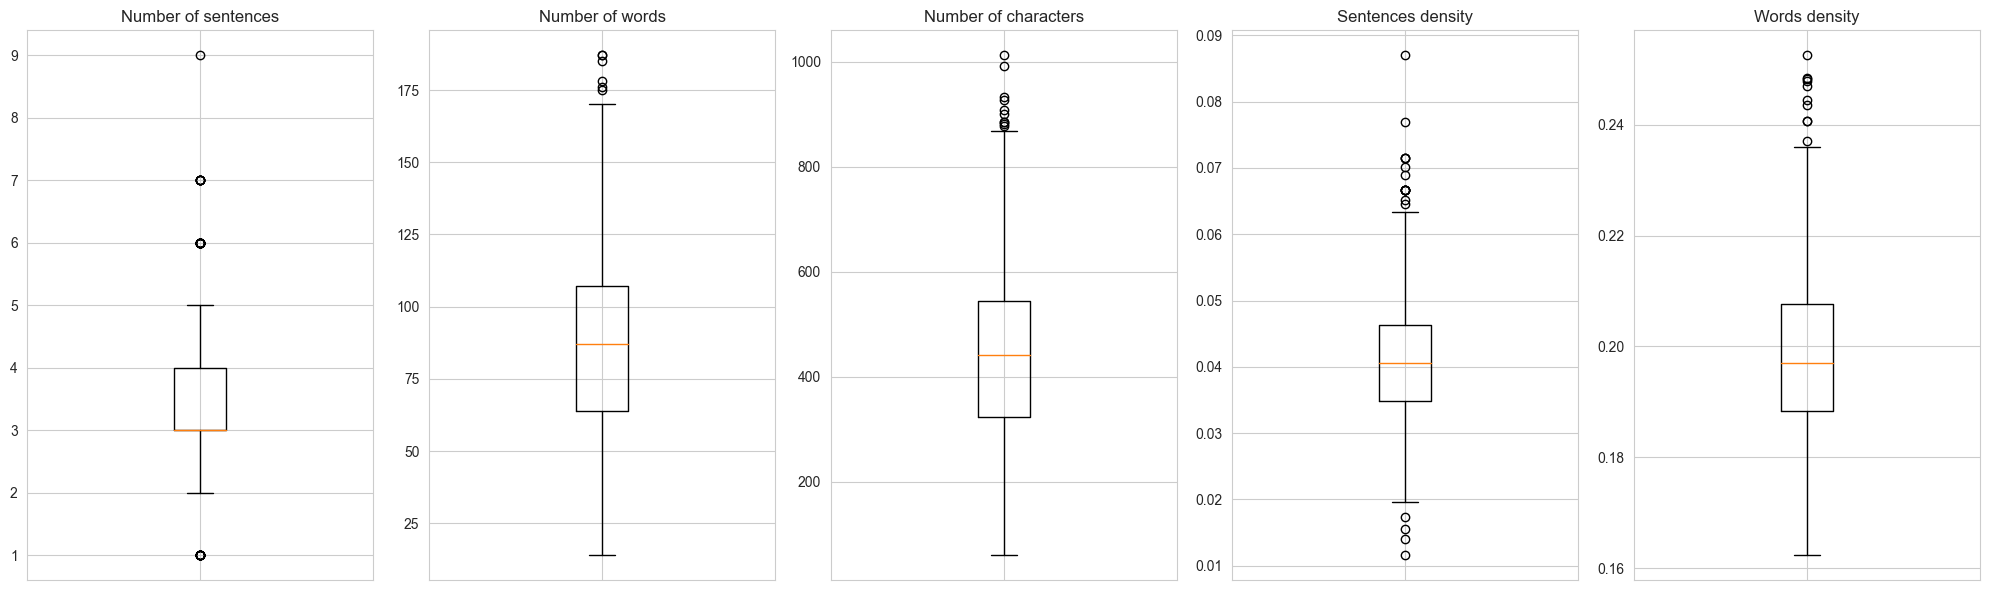

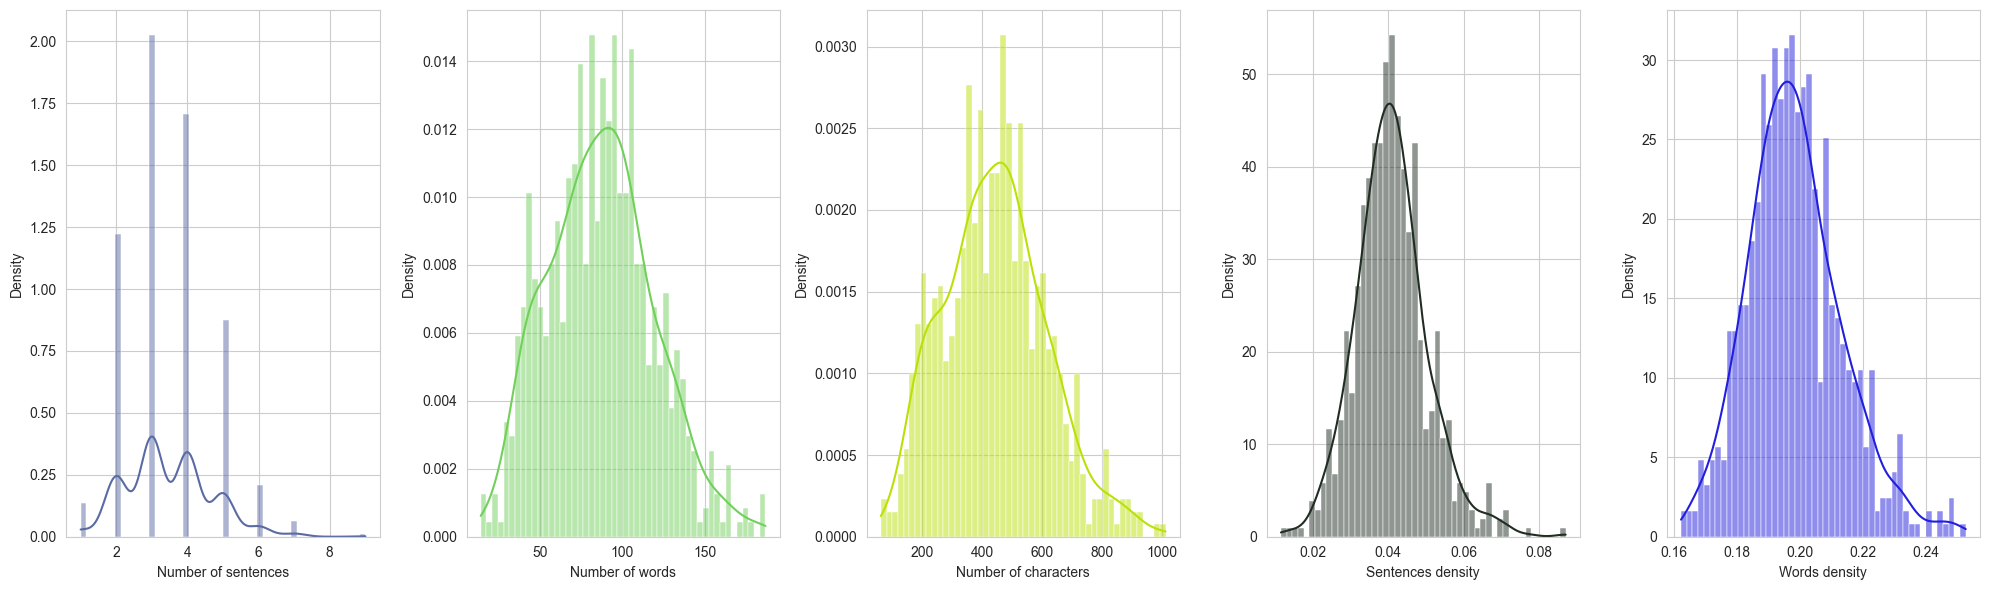

In [393]:
plot_vars = np.array([['sum_sent_count', 'sum_word_count', 'sum_char_count', 'sum_sent_density', 'sum_word_density']])
labels_dict = {'sum_sent_count': 'Number of sentences', 'sum_word_count': 'Number of words',
               'sum_char_count': 'Number of characters', 'sum_sent_density': 'Sentences density',
               'sum_word_density': 'Words density'}
# Plot the boxplots and histograms for the interesting columns
plot_boxplots(summary, plot_vars, labels_dict, figsize=fig_size)
plot_histograms(summary, plot_vars, labels_dict, figsize=fig_size)

TODO make description of the plots (The distribution appears to be right-skewed, as the mean...)
TODO make comparison

### Categorizing and POS tagging words

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. - Natural Language Processing with Python, by S. Bird, E. Klein and E. Loper

TODO fix to make the same as code

ADJ: adjective
ADP: adposition
ADV: adverb
CONJ: coordinating conjunction
DET: determiner
NOUN: noun
NUM: numeral
PRT: particle
PRON: pronoun
TODO (check) PUNCT/.: punctuation
VERB: verb
X: other

In [394]:
def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i, j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = pd.concat([df, pd.DataFrame([pos_tags])], ignore_index=True).fillna(0)

    return df.astype(int)

In [395]:
# Identify the taggings for the text variable
news_text = summary['seniorDescription'].values
df_text = get_pos_tags(news_text)
# Identify the taggings for the summary variable
news_summary = summary['juniorDescription'].values
df_summary = get_pos_tags(news_summary)

In [396]:
df_summary

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,2,4,1,1,7,15,3,4,0,10,3,0
1,1,5,0,3,3,17,3,3,0,11,4,0
2,3,7,0,1,7,18,4,3,2,10,6,0
3,0,7,1,2,7,19,0,2,0,7,5,0
4,1,6,0,2,9,17,4,1,1,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
680,7,17,4,3,12,37,2,6,1,23,7,0
681,8,13,1,3,13,31,0,3,1,18,9,0
682,7,19,0,4,14,51,4,2,2,23,13,1
683,10,12,5,2,11,25,2,2,3,18,6,0


In [397]:
df_text

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,59,95,19,16,82,261,39,20,9,119,73,0
1,40,58,14,9,44,150,26,20,5,69,48,0
2,135,107,55,29,120,410,26,44,28,224,190,1
3,13,31,5,7,42,115,2,15,0,42,33,0
4,135,199,57,53,225,704,186,25,17,258,291,0
...,...,...,...,...,...,...,...,...,...,...,...,...
680,114,150,27,31,144,468,20,43,8,196,156,0
681,26,30,11,7,29,107,7,6,3,45,43,0
682,69,53,7,14,44,243,12,13,8,107,93,1
683,74,44,5,12,44,218,4,17,5,102,132,0


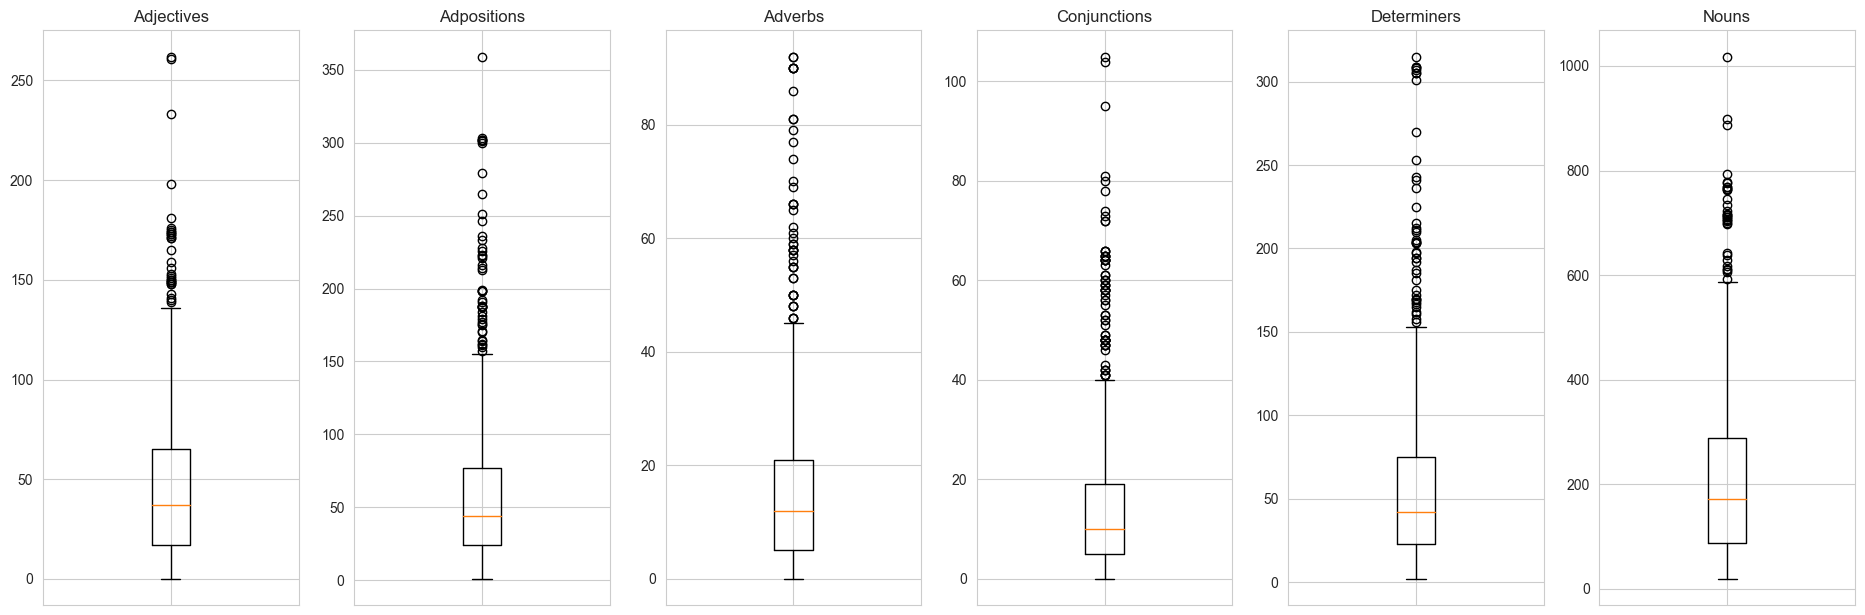

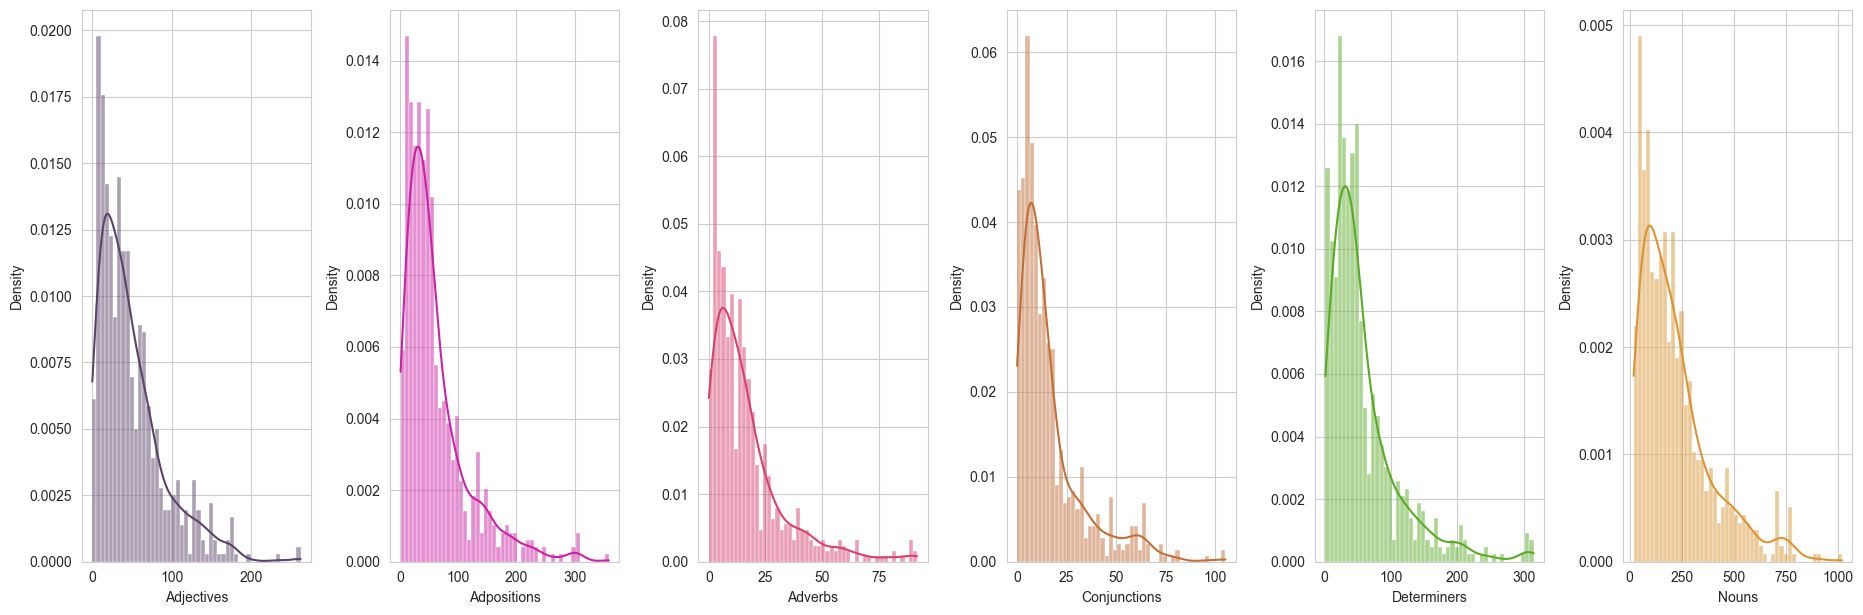

In [398]:
# Select the columns to plot: those related to pos taggings
plot_vars = np.array([['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN']])
labels_dict = {'ADJ': 'Adjectives', 'ADP': 'Adpositions',
               'ADV': 'Adverbs', 'CONJ': 'Conjunctions',
               'DET': 'Determiners', 'NOUN': 'Nouns'}
ratio = 0.8
# Plot a histograms of the variables
plot_boxplots(df_text, plot_vars, labels_dict, figsize=(15 / ratio, 5 / ratio))
plot_histograms(df_text, plot_vars, labels_dict, figsize=(15 / ratio, 5 / ratio))

### Use of stopwords and punctuations

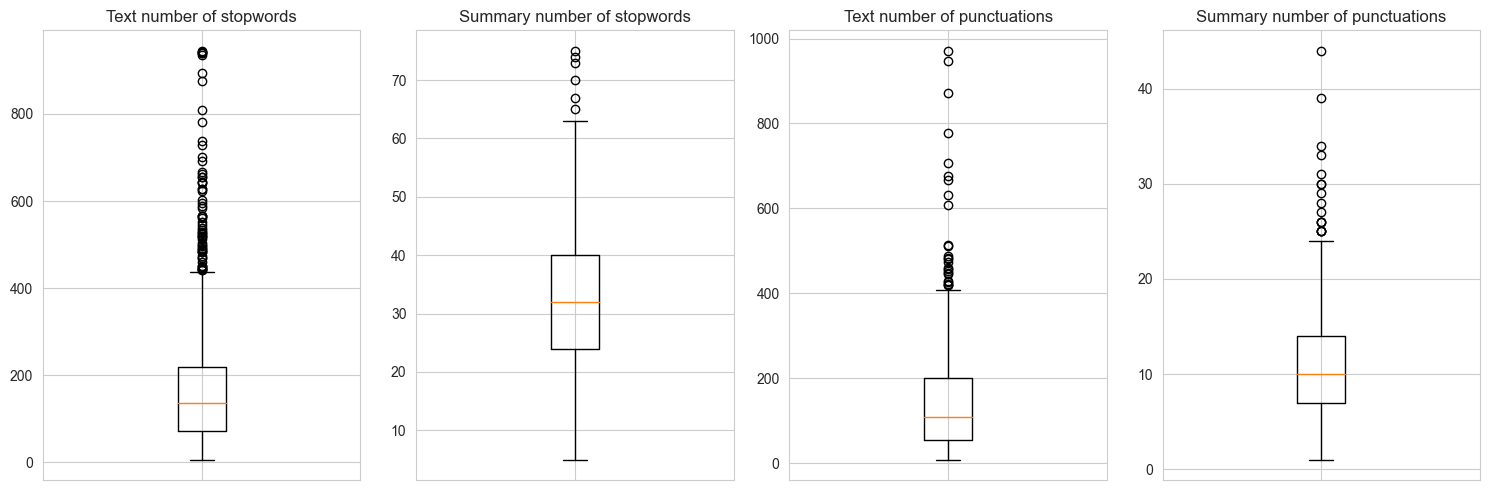

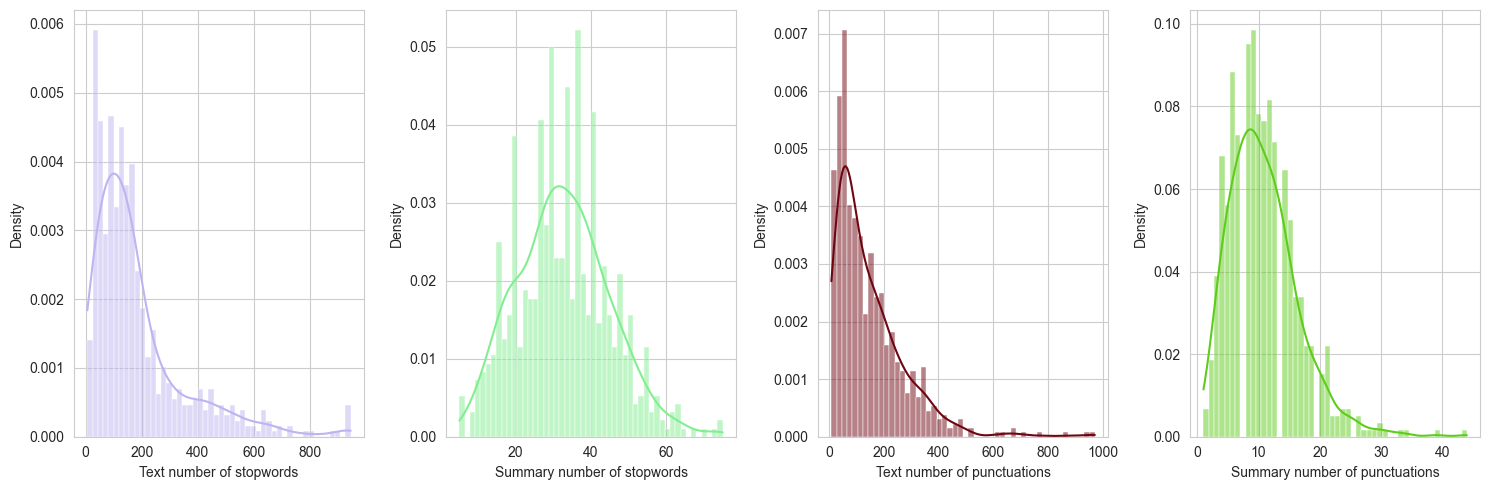

In [399]:
# Set the columns to plot, those relatives to stopwords and punctuation
plot_vars=np.array([['text_stopw_count', 'sum_stopw_count', 'text_punc_count','sum_punc_count']])
# Plot the bosplot and histograms
labels_dict = {'text_stopw_count': 'Text number of stopwords', 'sum_stopw_count': 'Summary number of stopwords',
               'text_punc_count': 'Text number of punctuations', 'sum_punc_count': 'Summary number of punctuations'}
plot_boxplots(summary, plot_vars, labels_dict, figsize=(15,5))
plot_histograms(summary, plot_vars, labels_dict, figsize=(15,5))

### Check for unknown words

TODO Rephrase:

It may be very common that unknown words are included in our texts and summaries, consequently, we should analyze them and you probably have to define how to deal with them. Most of the unknown words are names, surnames, locations or even mispelled words, which we have to decide to correct or not them.

In order to search for these words, we need a vocabulary to compare to. In this case, we use the Glove embeddings, checking if our words are included in those embeddings.

In [400]:
# may not be done tbh

### Most frequent terms and Wordclouds

A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words and the importance of each beeing shown with font size or color (the bigger the more frequent). This format is useful for quickly perceiving the most relevant terms on a document or set of documents. - Wikipedia

We will draw the wordcloud for the source texts and the summaries to compare if they are very similar, it will allow us to check that the relevant concepts have been correctly extracted in the summaries.

In [417]:
summaries = summary['juniorDescription'].values
texts = summary['seniorDescription'].values
long_summaries_string = ' '.join(summaries)
long_summaries_without_stopwords = ' '.join(remove_stopwords([long_summaries_string])[0])
long_texts_string = ' '.join(texts)
long_text_without_stopwords = ' '.join(remove_stopwords([long_texts_string])[0])


D:\CVUT\DIP\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


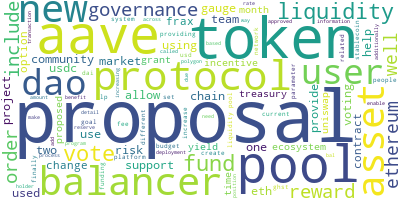

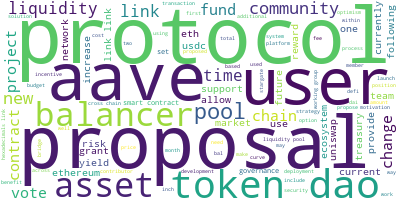

In [419]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud for summaries
wordcloud.generate(long_summaries_without_stopwords)
# Visualize the word cloud
display(wordcloud.to_image())

# Generate a word cloud for texts
wordcloud.generate(long_text_without_stopwords)
# Visualize the word cloud
display(wordcloud.to_image())

In [403]:
summary.drop_duplicates(subset=["seniorDescription"], inplace=True)

In [404]:
# save summaries dataframe as summaries.csv
summary.to_csv('data/summaries.csv', index=False)

In [405]:
print(er)

NameError: name 'er' is not defined

### Topic Modelling

In the upcoming phase, we will delve into the process of identifying the main subjects or topics discussed within our text data. This process is commonly known as topic modeling. According to Wikipedia, topic modeling is a statistical modeling approach used in machine learning and natural language processing to discover the underlying "topics" present in a collection of documents.

By employing an unsupervised learning technique, topic modeling aims to uncover the semantic structures embedded within a text and group related words into coherent topic representations. This helps us gain insights into the key themes or subjects covered in our text data.

In particular, we will focus on one popular technique called Latent Dirichlet Allocation (LDA), which is widely used for topic modeling. We will apply LDA to transform our collection of source texts into a set of topics. This process involves automatically assigning words to different topics based on their co-occurrence patterns and probability distributions within the text data. - Topic Modeling with Gensim (Python), by Selva Prabhakaran

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [411]:
stop_words = stopwords.words('english')
# stop_words = set(stopwords.words('english'))
stop_words.extend(['would'])

data_words = remove_stopwords(summaries)
print(data_words[:1][0][:30])

['proposal', 'integrating', 'balancer', 'boosted', 'pools', 'inch', 'aggregation', 'protocol', 'allow', 'inch', 'access', 'cheap', 'liquidity', 'trade', 'routing', 'position', 'inch', 'aggregator', 'able', 'rapidly', 'integrate', 'new', 'boosted', 'pools', 'launched', 'future']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

To gain insights and interpret the identified topics effectively, we can utilize data visualization techniques. One useful tool is the pyLDAvis library, which allows us to create interactive visualizations. In the generated plot, each circle represents a topic. The size of the circle indicates the importance of the topic within the texts, while the distance between circles reflects their similarity.

By selecting a specific topic, we can explore the most relevant words associated with it. The visualization displays both the frequency of each word appearing in the topic and its occurrence in the entire corpus. This information helps us understand the key terms and concepts related to a particular topic.

The relevance metric parameter, denoted as λ, plays a crucial role in the visualization. It allows us to differentiate between words that are exclusive to the topic (closer to 0) and words that have a high probability of being included in the selected topic (closer to 1). Adjusting this parameter enables us to assign a meaningful "name" or label to a topic based on the words that are most representative and distinctive for that topic.

In [ ]:
import os
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./data_analysis/ldavis_prepared_'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './data_analysis/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

### Count Vectorized

The Count Vectorization method is a technique that replaces each word in a corpus (a group of texts) with the count of occurrences of that word. This process creates a document-term matrix where the most frequently appearing words are assigned higher values.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    ''' Draw a barplot showing the tenth most common words in the data
        Input:
        - count_data: tuple, containing pairs of document-term and its ocurrencies in the text
        - count_vectorizer: CountVectorizer object
    '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [ ]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(cleaned_text)
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
print(doc_term_matrix)

In [ ]:
plot_10_most_common_words(tf, tf_vectorizer)


In [ ]:
summary[summary.duplicated(subset=["seniorDescription"], keep=False)]['seniorDescription']

In [ ]:
display(summary)